# Fit Inspection

This notebook visually inspects light curve fits for each target in a given survey. 


In [1]:
import sys
from pathlib import Path

import sndata
import yaml

sys.path.insert(0, '../')

from phot_class import fit_funcs
from phot_class import models
from phot_class import utils
from phot_class.classification import run_classification_fits


We begin by defining the data release to inspect light-curves for. We also define which parameters to vary while fitting and load a dictionary of priors from file.


In [2]:
# Set this to the survey you want to inspect
# e.g. sndata.des.sn3yr, sndata.sdss.sako18
survey = sndata.sdss.sako18

# Specify which model parameters you want to vary while fitting
# Options: 'z', t0', 'x0', 'x1', 'c'
vparams = ['t0', 'amplitude', 'x1', 'c']

# Specify the path where to load / save prior values from
config_path = Path('../config_files/sdss_config.yml')


Next we build an iterable over the object ids for each supernova we want to fit.

In [3]:
# Make sncosmo aware of the models and bandpasses we are using
models.register_sources(force=True)
survey.download_module_data()
survey.register_filters(force=True)

# Define an iterable over object ids
targets = survey.get_available_ids()
total_targets = len(targets)

target_iter = iter(targets)
band_names = survey.band_names
lambda_eff = survey.lambda_effective


Finally, we iterate over each supernova one at a time and fit each light-curve using the priors we loaded in from file earlier. To inspect fit results for a specific target, manually specify ``target_for_inspection`` as the desired object id.

In [4]:
target_for_inspection = '10028' # next(target_iter)
i = survey.get_available_ids().index(target_for_inspection)
print(f'{i + 1} / {total_targets}')


5 / 10258


Inspecting: 10028

Hsiao prior: {'t0': 2453698.8, 'z': 0.064256}

Hsiao kwargs: {'bounds': {'t0': [2453688.8, 2453708.8]}, 'phase_range': [-20, 50]}

sn91bg prior: {'t0': 2453698.8, 'z': 0.064256}

sn91bg kwargs: {'bounds': {'c': [0, 1], 't0': [2453688.8, 2453708.8], 'x1': [0.65, 1.25]}, 'phase_range': [-20, 50]}

chisq / ndof = 996.850853268911 / 38 = 26.232917191287132


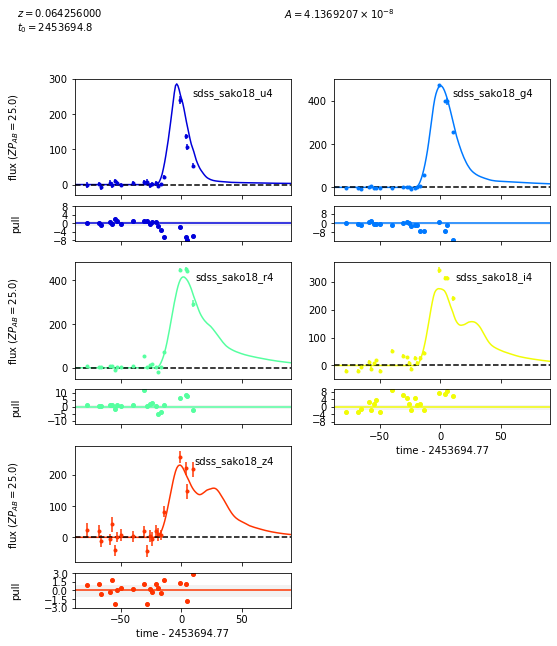

chisq / ndof = 188.01835259010844 / 7 = 26.859764655729776


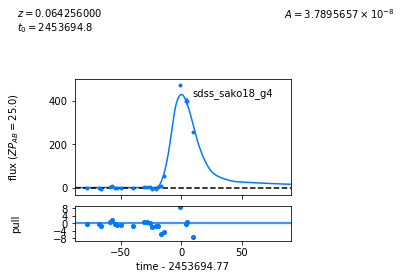

chisq / ndof = 40.89530151585611 / 7 = 5.842185930836587


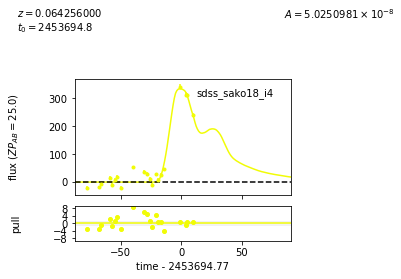

chisq / ndof = 64.00098767090297 / 7 = 9.142998238700425


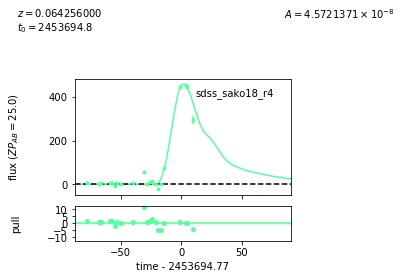

chisq / ndof = 55.03459820756154 / 7 = 7.862085458223077


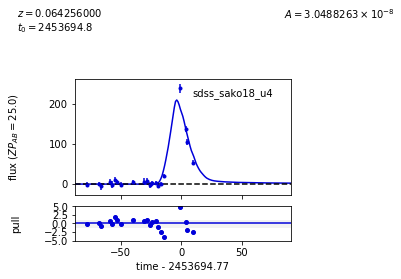

chisq / ndof = 16.075092315545994 / 7 = 2.2964417593637134


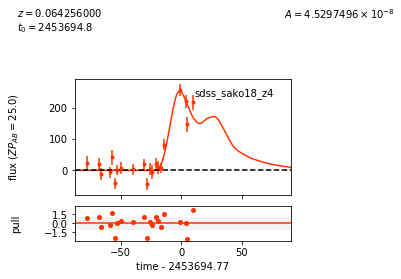

chisq / ndof = 4437.056836894322 / 26 = 170.65603218824316


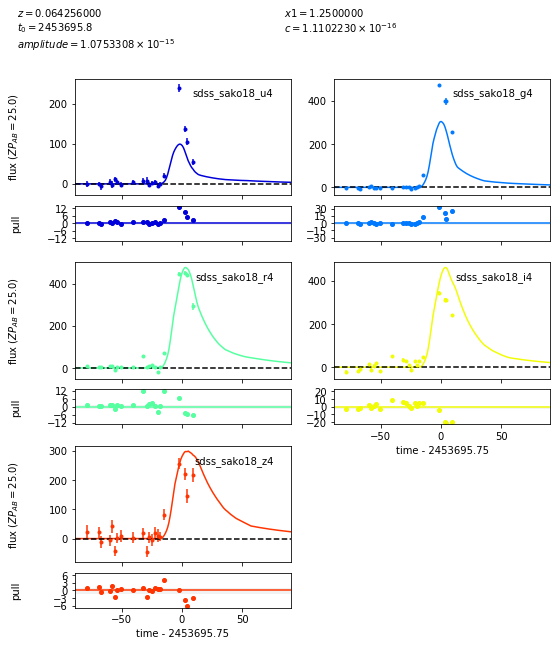

chisq / ndof = 213.82371861065198 / 3 = 71.27457287021733


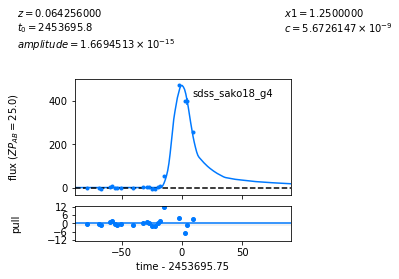

chisq / ndof = 169.84195673044644 / 3 = 56.61398557681548


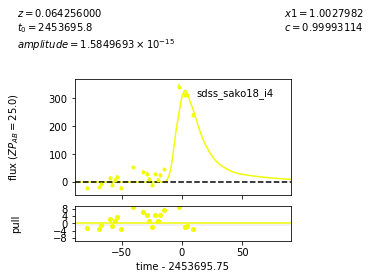

chisq / ndof = 250.3259640321899 / 3 = 83.44198801072996


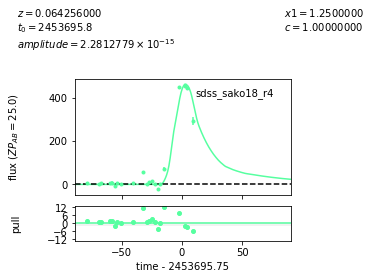

chisq / ndof = 12.992254319658658 / 3 = 4.330751439886219


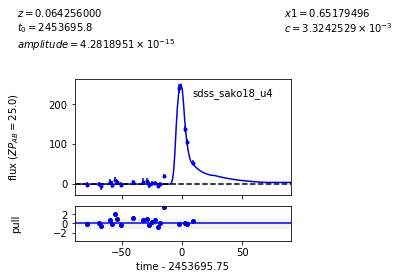

chisq / ndof = 38.87171144675509 / 3 = 12.957237148918365


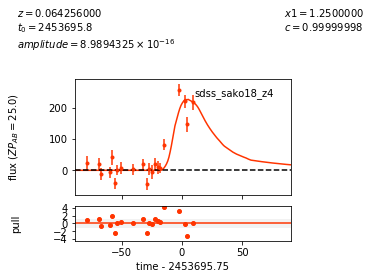

In [5]:
print('Inspecting:', target_for_inspection)

# We reload the config data each time we fit. This means
# you can vary the parameters in the config file to
# improve the fit results in a semi-interactive way.
with open(config_path) as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

# Load data. Note that we drop any data in the CSP NIR filters
# These filters tend to throw off our fits
target_data = survey.get_data_for_id(target_for_inspection)
target_data = target_data[target_data['band'] != 'csp_dr3_Ydw']
target_data = target_data[target_data['band'] != 'csp_dr3_Y']
z = target_data.meta['redshift']

hsiao_prior, hsiao_kwargs, sn91bg_prior, sn91bg_kwargs = \
    utils.parse_config_dict(target_for_inspection, config)

print(f'\nHsiao prior: {hsiao_prior}')
print(f'\nHsiao kwargs: {hsiao_kwargs}')
print(f'\nsn91bg prior: {sn91bg_prior}')
print(f'\nsn91bg kwargs: {sn91bg_kwargs}')

print()
fit_results = run_classification_fits(
    target_data.meta['obj_id'],
    target_data,
    vparams=vparams,
    fit_func=fit_funcs.simple_fit,
    priors_hs=hsiao_prior,
    priors_bg=sn91bg_prior,
    kwargs_hs=hsiao_kwargs,
    kwargs_bg=sn91bg_kwargs,
    show_plots=True
)
